In [2]:

import os
import time

import psutil
import tensorflow as tf
import numpy as np

from modules.training.cme_modeling import ModelBuilder as MB

In [3]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [4]:
def benchmark_function(func, args=(), kwargs=None, num_runs=100):
    """
    Generic benchmark utility for any function.
    
    :param func: Function to benchmark
    :param args: Tuple of positional arguments for the function
    :param kwargs: Dictionary of keyword arguments for the function
    :param num_runs: Number of runs for averaging timing
    :return: Dictionary containing timing and memory statistics
    """
    if kwargs is None:
        kwargs = {}
    global result
    process = psutil.Process(os.getpid())
    execution_times = []
    memory_usages = []

    # Warmup run
    _ = func(*args, **kwargs)

    # Clear any cached memory
    tf.keras.backend.clear_session()

    for _ in range(num_runs):
        mem_before = process.memory_info().rss / 1024 / 1024

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()

        mem_after = process.memory_info().rss / 1024 / 1024

        execution_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)

        tf.keras.backend.clear_session()

    times_ms = np.array(execution_times) * 1000
    memory_mb = np.array(memory_usages)

    return {
        'time_mean_ms': np.mean(times_ms),
        'time_std_ms': np.std(times_ms),
        'memory_mean_mb': np.mean(memory_mb),
        'memory_max_mb': np.max(memory_mb),
        'last_result': result
    }

In [5]:
y_true = tf.constant([[1.0],
                      [5.0],
                      [0.0]])

z_pred = tf.constant([[1.0, 1.0],
                      [2.0, -1.0],
                      [3.0, 1.0]])

# print shapes
print(f"y_true shape: {y_true.shape}")
print(f"z_pred shape: {z_pred.shape}")

y_true shape: (3, 1)
z_pred shape: (3, 2)


In [6]:
res = mb.pds_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 176.6667


In [7]:
res = mb.pds_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 176.6667


In [8]:
res = mb.pdc_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0714


In [9]:
res = mb.pdc_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0714


In [10]:
# Parameters
num_points = 5000  # 201 points for labels from -100 to 100 inclusive

# Create evenly spaced labels from -100 to 100
labels = np.linspace(-5000, 5000, num_points)
# update the dimension of labels
labels = np.expand_dims(labels, axis=1)

# Generate points like (0, 0), (1, 1), ..., (200, 200)
points = np.array([(i, i) for i in range(num_points)])

# convert to tensor float32
labels = tf.constant(labels, dtype=tf.float32)
points = tf.constant(points, dtype=tf.float32)

print(f"Labels shape: {labels.shape}")
print(f"Points shape: {points.shape}")

# Random sample weights between 0 and 1
sample_weights = np.random.rand(num_points)

Labels shape: (5000, 1)
Points shape: (5000, 2)


In [11]:
stats = benchmark_function(
    mb.pds_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 166966887186432.0000
Time: 52.995 ± 16.855 ms
Memory peak: 0.082 MB


In [12]:
stats = benchmark_function(
    mb.pds_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 250350204354560.0000
Time: 34.857 ± 11.271 ms
Memory peak: 0.062 MB


In [13]:
stats = benchmark_function(
    mb.pdc_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 0.0000
Time: 149.464 ± 15.899 ms
Memory peak: 0.062 MB


In [17]:
stats = benchmark_function(
    mb.pdc_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: -0.0000
Time: 40.952 ± 15.438 ms
Memory peak: 0.004 MB


Epoch 1/600
Dy_mean: Tensor("pdc_loss/truediv:0", shape=(), dtype=float32), Dz_mean: Tensor("pdc_loss/truediv_1:0", shape=(), dtype=float32)
Dy_centered: Tensor("pdc_loss/sub_3:0", shape=(None, None), dtype=float32), Dz_centered: Tensor("pdc_loss/sub_4:0", shape=(None, None), dtype=float32)
Tensor("pdc_loss/set_diag:0", shape=(None, None), dtype=float32)
cov_Dy_Dz: Tensor("pdc_loss/Sum_3:0", shape=(), dtype=float32), var_Dy: Tensor("pdc_loss/Sum_4:0", shape=(), dtype=float32), var_Dz: Tensor("pdc_loss/Sum_5:0", shape=(), dtype=float32)
pcc: Tensor("pdc_loss/truediv_2:0", shape=(), dtype=float32)
Dy_mean: Tensor("pdc_loss/truediv:0", shape=(), dtype=float32), Dz_mean: Tensor("pdc_loss/truediv_1:0", shape=(), dtype=float32)
Dy_centered: Tensor("pdc_loss/sub_3:0", shape=(None, None), dtype=float32), Dz_centered: Tensor("pdc_loss/sub_4:0", shape=(None, None), dtype=float32)
Tensor("pdc_loss/set_diag:0", shape=(None, None), dtype=float32)
cov_Dy_Dz: Tensor("pdc_loss/Sum_3:0", shape=(), dtyp

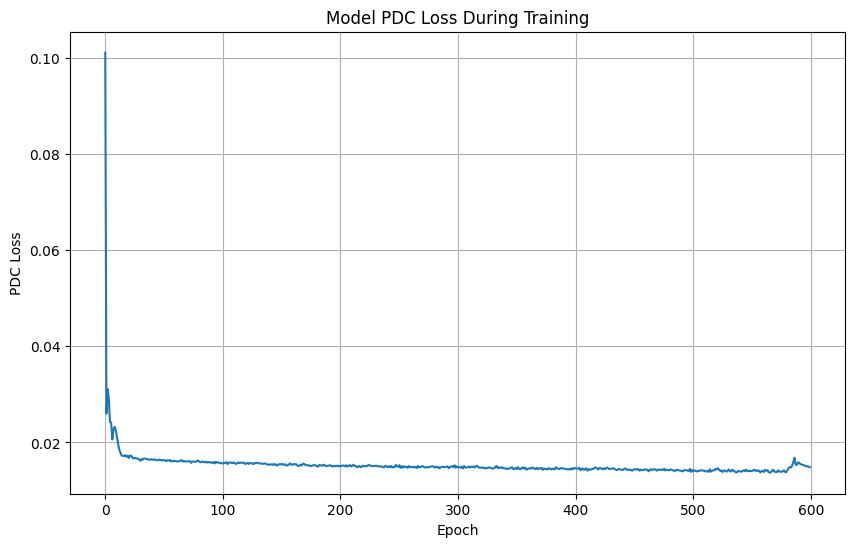

4/4 [==============================] - 0s 4ms/step


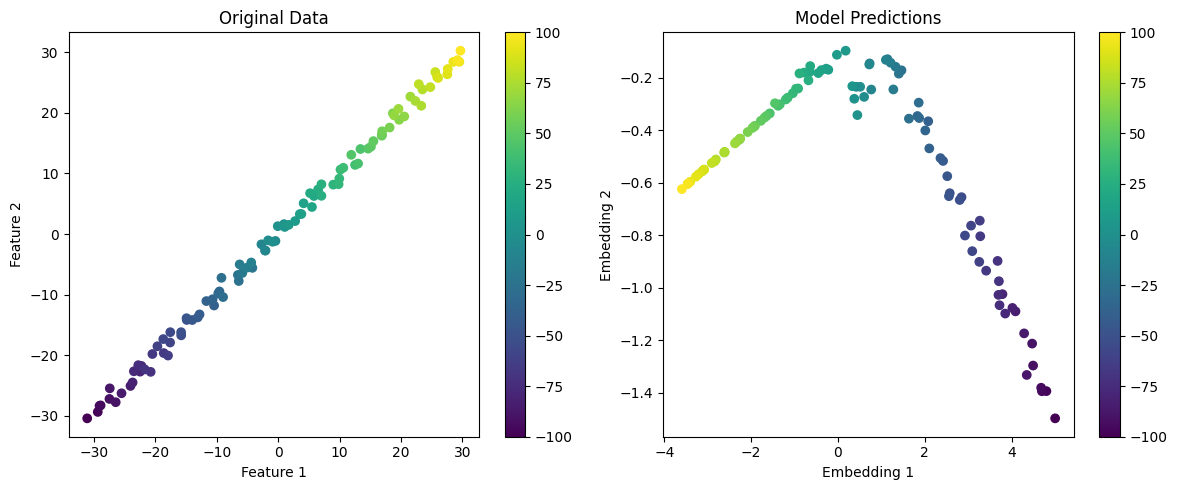

In [19]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


class PDCTrainer:
    def __init__(self, input_dim=2, hidden_dims=[64, 32], output_dim=2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers
        for dim in self.hidden_dims:
            x = Dense(dim, activation='relu')(x)

        # Output layer
        # x =  NormalizeLayer(name='normalize_layer')(x)
        outputs = Dense(self.output_dim)(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def pdc_loss(self, y_true, y_pred):
        return mb.pdc_loss_vec(y_true, y_pred, self.phase_manager)

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-100, 100, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 1, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions"""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, p_value = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation, p_value

    def train(self, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data()

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self.pdc_loss
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation, p_value = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation, p_value

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model PDC Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('PDC Loss')
        plt.grid(True)
        plt.show()


# Training example
trainer = PDCTrainer(input_dim=2, hidden_dims=[8, 16, 32, 32, 16, 8], output_dim=2)
history, final_correlation, p_value = trainer.train(epochs=600, batch_size=64)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plot training history
trainer.plot_training_history(history)

# Visualize results
X_test, y_test = trainer.generate_synthetic_data(num_points=100)
predictions = trainer.model.predict(X_test)

plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Predictions
plt.subplot(1, 2, 2)
plt.scatter(predictions[:, 0], predictions[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Model Predictions')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')

plt.tight_layout()
plt.show()

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 1.1653
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1232
Epoch 3/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7356
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.4690
Epoch 5/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.3903
Epoch 6/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.3649
Epoch 7/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.3518
Epoch 8/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3472
Epoch 9/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.3463
Epoch 10/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.3456
Epoch 11/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.3442
Epoch 12/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3424
Epoch 13/1000
1/1 [====================

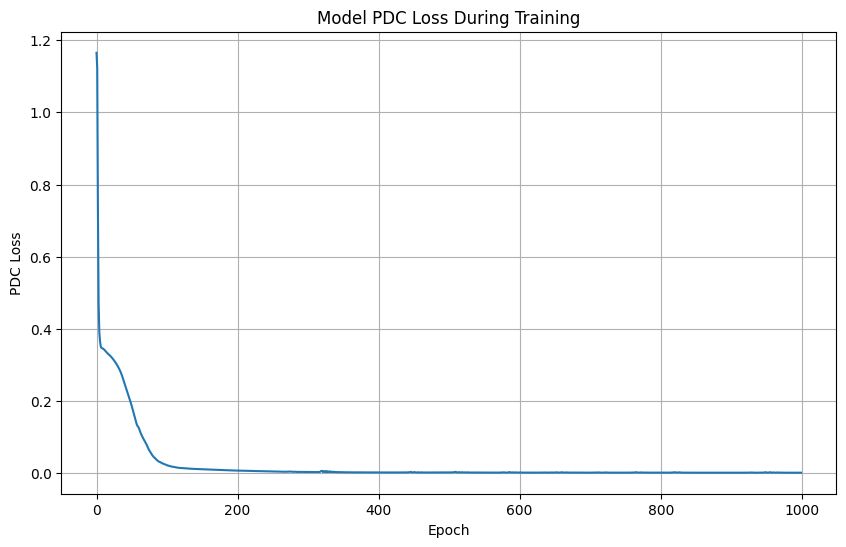

157/157 [==============================] - 1s 4ms/step


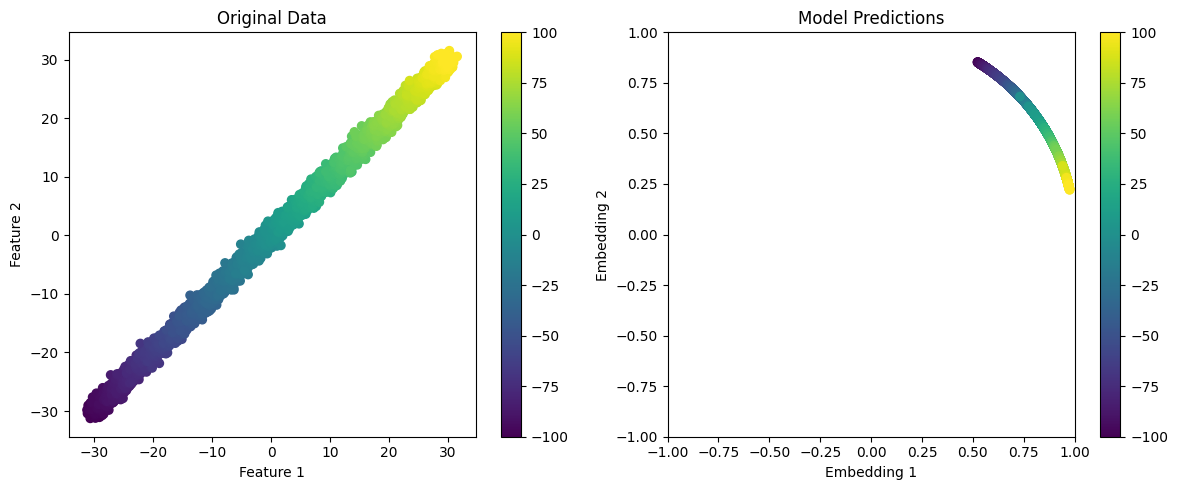

In [21]:
from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


class PDCTrainer:
    def __init__(self, input_dim=2, hidden_dims=[64, 32], output_dim=2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers
        for dim in self.hidden_dims:
            x = Dense(dim, activation='relu')(x)

        # Output layer

        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def pdc_loss(self, y_true, y_pred):
        return mb.pdc_loss_vec(y_true, y_pred, self.phase_manager)

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-100, 100, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 1, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions"""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, p_value = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation, p_value

    def train(self, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data()

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self.pdc_loss
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation, p_value = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation, p_value

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model PDC Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('PDC Loss')
        plt.grid(True)
        plt.show()


# Training example
trainer = PDCTrainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation, p_value = trainer.train(epochs=1000, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plot training history
trainer.plot_training_history(history)

# Visualize results
X_test, y_test = trainer.generate_synthetic_data(num_points=5000)
predictions = trainer.model.predict(X_test)
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Predictions
plt.subplot(1, 2, 2)
plt.scatter(predictions[:, 0], predictions[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Model Predictions')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

Epoch 1/1500
1/1 [==============================] - 2s 2s/step - loss: 1.0679
Epoch 2/1500
1/1 [==============================] - 0s 18ms/step - loss: 0.9105
Epoch 3/1500
1/1 [==============================] - 0s 14ms/step - loss: 0.6234
Epoch 4/1500
1/1 [==============================] - 0s 11ms/step - loss: 0.3037
Epoch 5/1500
1/1 [==============================] - 0s 12ms/step - loss: 0.1488
Epoch 6/1500
1/1 [==============================] - 0s 13ms/step - loss: 0.1030
Epoch 7/1500
1/1 [==============================] - 0s 11ms/step - loss: 0.0882
Epoch 8/1500
1/1 [==============================] - 0s 14ms/step - loss: 0.0860
Epoch 9/1500
1/1 [==============================] - 0s 11ms/step - loss: 0.0845
Epoch 10/1500
1/1 [==============================] - 0s 13ms/step - loss: 0.0830
Epoch 11/1500
1/1 [==============================] - 0s 13ms/step - loss: 0.0817
Epoch 12/1500
1/1 [==============================] - 0s 17ms/step - loss: 0.0803
Epoch 13/1500
1/1 [====================

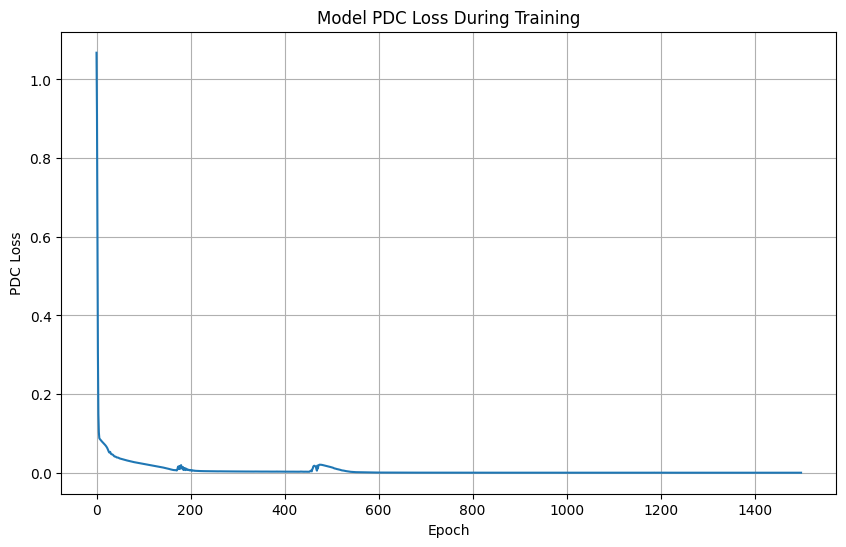

157/157 [==============================] - 1s 5ms/step


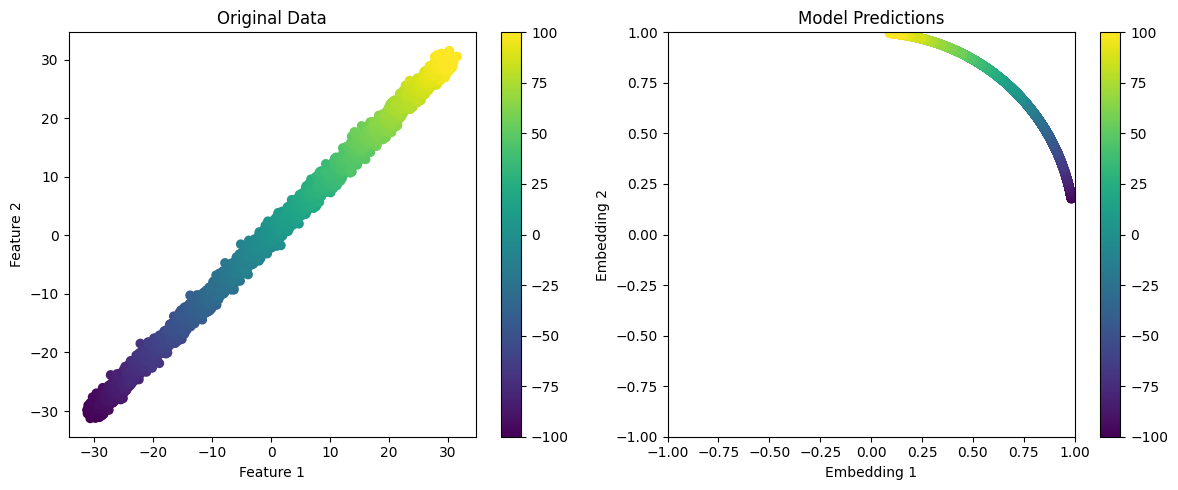

In [24]:
from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


class PDCTrainer:
    def __init__(self, input_dim=2, hidden_dims=[64, 32], output_dim=2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers
        for dim in self.hidden_dims:
            x = Dense(dim, activation='relu')(x)

        # Output layer

        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def pdc_loss(self, y_true, y_pred):
        return mb.pdc_loss_linear_vec(y_true, y_pred, self.phase_manager)

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-100, 100, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 1, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions"""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, p_value = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation, p_value

    def train(self, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data()

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self.pdc_loss
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation, p_value = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation, p_value

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model PDC Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('PDC Loss')
        plt.grid(True)
        plt.show()


# Training example
trainer = PDCTrainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation, p_value = trainer.train(epochs=1500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plot training history
trainer.plot_training_history(history)

# Visualize results
X_test, y_test = trainer.generate_synthetic_data(num_points=5000)
predictions = trainer.model.predict(X_test)
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Predictions
plt.subplot(1, 2, 2)
plt.scatter(predictions[:, 0], predictions[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Model Predictions')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

Epoch 1/10000
1/1 [==============================] - 1s 847ms/step - loss: 3.5355
Epoch 2/10000
1/1 [==============================] - 0s 9ms/step - loss: 2.8962
Epoch 3/10000
1/1 [==============================] - 0s 8ms/step - loss: 2.1456
Epoch 4/10000
1/1 [==============================] - 0s 8ms/step - loss: 1.6100
Epoch 5/10000
1/1 [==============================] - 0s 20ms/step - loss: 1.4772
Epoch 6/10000
1/1 [==============================] - 0s 11ms/step - loss: 1.5111
Epoch 7/10000
1/1 [==============================] - 0s 9ms/step - loss: 1.5399
Epoch 8/10000
1/1 [==============================] - 0s 11ms/step - loss: 1.5547
Epoch 9/10000
1/1 [==============================] - 0s 8ms/step - loss: 1.5594
Epoch 10/10000
1/1 [==============================] - 0s 10ms/step - loss: 1.5607
Epoch 11/10000
1/1 [==============================] - 0s 11ms/step - loss: 1.5604
Epoch 12/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.5589
Epoch 13/10000
1/1 [=========

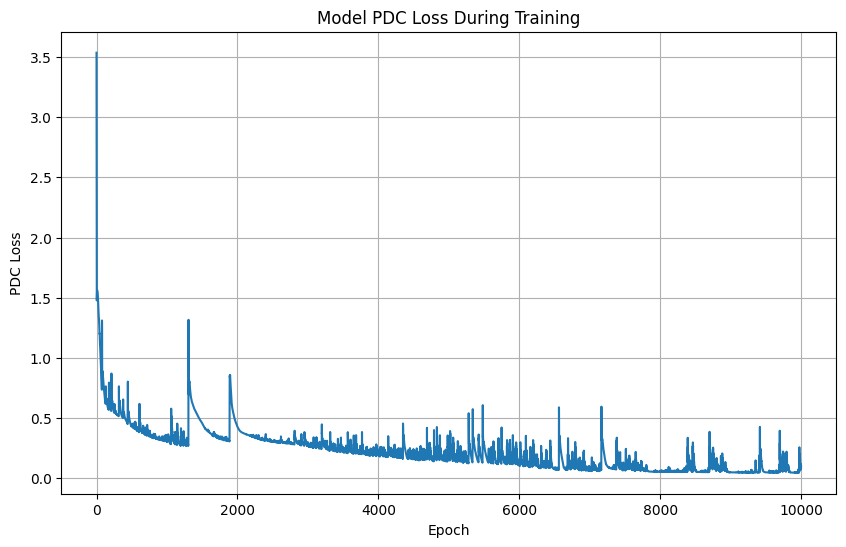

157/157 [==============================] - 1s 4ms/step


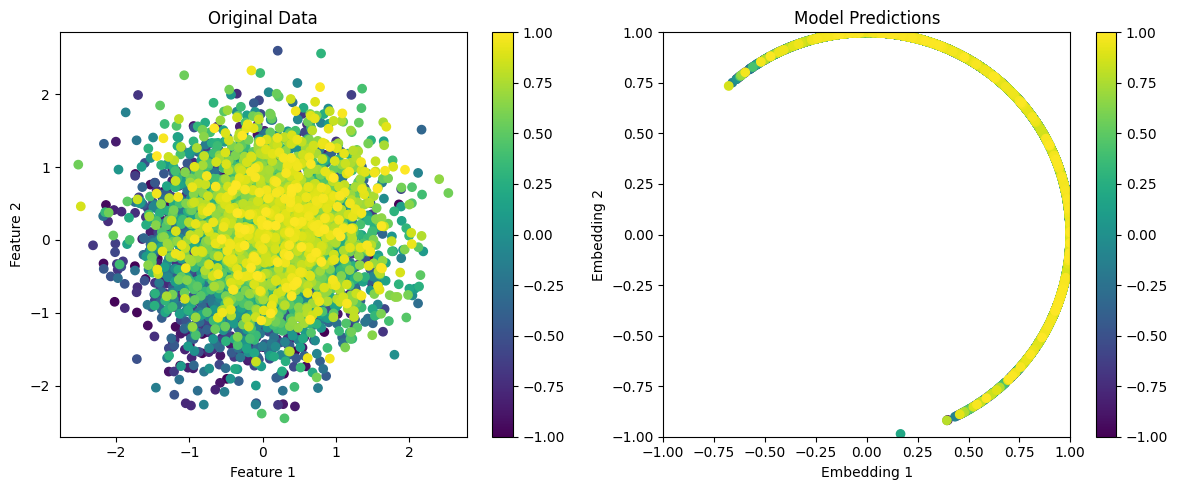

In [43]:
from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


class PDCTrainer:
    def __init__(self, input_dim=2, hidden_dims=[64, 32], output_dim=2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers
        for dim in self.hidden_dims:
            x = Dense(dim, activation='relu')(x)

        # Output layer

        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def pdc_loss(self, y_true, y_pred):
        return mb.pds_loss_linear_vec(y_true, y_pred, self.phase_manager)

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-1, 1, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 1, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions"""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, p_value = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation, p_value

    def train(self, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data()

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self.pdc_loss
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation, p_value = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation, p_value

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model PDC Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('PDC Loss')
        plt.grid(True)
        plt.show()


# Training example
trainer = PDCTrainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation, p_value = trainer.train(epochs=10000, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plot training history
trainer.plot_training_history(history)

# Visualize results
X_test, y_test = trainer.generate_synthetic_data(num_points=5000)
predictions = trainer.model.predict(X_test)
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Predictions
plt.subplot(1, 2, 2)
plt.scatter(predictions[:, 0], predictions[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Model Predictions')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [39]:
from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


class PDCTrainer:
    def __init__(self, input_dim=2, hidden_dims=[64, 32], output_dim=2):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers
        for dim in self.hidden_dims:
            x = Dense(dim, activation='relu')(x)

        # Output layer

        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def pdc_loss(self, y_true, y_pred):
        return mb.pds_loss_vec(y_true, y_pred, self.phase_manager)

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-1, 1, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 1, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions"""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, p_value = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation, p_value

    def train(self, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data()

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=self.pdc_loss
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation, p_value = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation, p_value

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model PDC Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('PDC Loss')
        plt.grid(True)
        plt.show()


# Training example
trainer = PDCTrainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation, p_value = trainer.train(epochs=1500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Plot training history
trainer.plot_training_history(history)

# Visualize results
X_test, y_test = trainer.generate_synthetic_data(num_points=5000)
predictions = trainer.model.predict(X_test)
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Predictions
plt.subplot(1, 2, 2)
plt.scatter(predictions[:, 0], predictions[:, 1], c=y_test.flatten(), cmap='viridis')
plt.colorbar()
plt.title('Model Predictions')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

Epoch 1/100000
1/1 [==============================] - 1s 981ms/step - loss: 1.0449
Epoch 2/100000
1/1 [==============================] - 0s 10ms/step - loss: 0.9952
Epoch 3/100000
1/1 [==============================] - 0s 9ms/step - loss: 0.9015
Epoch 4/100000
1/1 [==============================] - 0s 7ms/step - loss: 0.8815
Epoch 5/100000
1/1 [==============================] - 0s 12ms/step - loss: 0.8629
Epoch 6/100000
1/1 [==============================] - 0s 11ms/step - loss: 0.8514
Epoch 7/100000
1/1 [==============================] - 0s 10ms/step - loss: 0.8438
Epoch 8/100000
1/1 [==============================] - 0s 9ms/step - loss: 0.8393
Epoch 9/100000
1/1 [==============================] - 0s 9ms/step - loss: 0.8368
Epoch 10/100000
1/1 [==============================] - 0s 11ms/step - loss: 0.8329
Epoch 11/100000
1/1 [==============================] - 0s 11ms/step - loss: 0.8264
Epoch 12/100000
1/1 [==============================] - 0s 12ms/step - loss: 0.8156
Epoch 13/100000


KeyboardInterrupt: 